<a href="https://colab.research.google.com/github/abbasmammadov/Facial-Expression-Recognition/blob/main/Models/Resnet_50_SGD_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount your drive first - you can do it once
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing necessary modules
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import torchvision.datasets as dset
import torchvision.transforms as T

In [ ]:
#hyperparameters start form 
lr = 1e-3
batch_size = 128
epochs = 50

#device
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  print('GPU available')
else:
  print('training is done on CPU')

GPU available


In [ ]:
#now let's load the dataset into the 'dataloader' package of pytorch
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
#first step is creating an augmentation cell using transforms of pytorch
train_augs = T.Compose([T.RandomHorizontalFlip(p=0.5), 
                        T.RandomRotation(degrees=(-10, +10)),
                        T.RandomAffine(degrees=(-10, +10), translate=(0.1, 0.2)),
                        T.Resize((48, 48)),
                        T.ToTensor()])

valid_augs = T.Compose([T.ToTensor()])

test_augs = T.Compose([T.ToTensor()])

In [ ]:
data_path = '/content/drive/MyDrive/datasets'
train_path = os.path.join(data_path, 'train')
validation_path = os.path.join(data_path, 'validation')
test_path = os.path.join(data_path, 'test')

In [ ]:
trainset = ImageFolder(train_path, transform=train_augs)
validset = ImageFolder(validation_path, transform=valid_augs)
testset = ImageFolder(test_path, transform=test_augs)
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")
print(f"Total no. of examples in testset : {len(testset)}")

Total no. of examples in trainset : 49297
Total no. of examples in validset : 3599
Total no. of examples in testset : 3589


In [ ]:
print(trainset.class_to_idx)

{'anger': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


chosen index:  37379


Text(0.5, 1.0, '4')

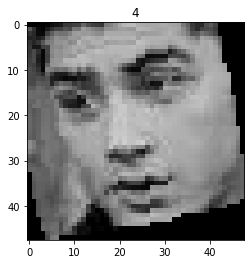

In [ ]:
#we can view some images and their labels
import matplotlib.pyplot as plt
idx = np.random.randint(low=0, high=len(trainset)-1)
print('chosen index: ', idx)
image, label = trainset[idx] # the image has format of h, w, c -> so it have to be reshaped
plt.imshow(image.permute(1, 2, 0))
plt.title(label)

In [ ]:
#now let's read the dataset using pytorch's dataloader
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)
testloader = DataLoader(testset)
print('total batches in trainloader: ', len(trainloader), ', validloader: ', len(validloader), ', and testloader', len(testloader))

total batches in trainloader:  386 , validloader:  29 , and testloader 3589


In [ ]:
#checking the shapes of each batch
for images, labels in trainloader:
  break
print(f'shape of a batch of images: {images.shape}')
print(f'shape of a batch of labels: {labels.shape}')

shape of a batch of images: torch.Size([128, 3, 48, 48])
shape of a batch of labels: torch.Size([128])


In [ ]:
from torchvision import models

In [ ]:
model = models.resnet50(pretrained=True)
#modify the last layer -> to have a linear layer whose output is 7
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 7)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#accuracy of the model
from tqdm import tqdm
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
#building the train and eval functions (training the model on the training and on the validation set)
def train_model(model, dataloader, optimizer, current_epoch):

  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[TRAIN]' + str(current_epoch + 1) + "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    logits = model(images)
    loss = nn.CrossEntropyLoss()(logits,  labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc / len(dataloader)

def eval_model(model, dataloader, current_epoch):

  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[VALID]' + str(current_epoch + 1) + "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    logits = model(images)
    loss = nn.CrossEntropyLoss()(logits,  labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc / len(dataloader)

def test_model(model, dataloader, current_epoch=1):

  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[TEST]' + str(current_epoch) + "/" + str(1))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    logits = model(images)
    loss = nn.CrossEntropyLoss()(logits,  labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc / len(dataloader)

In [ ]:
#now let's train the model
from torch import optim
#optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=1e-2, nesterov=True) 

In [ ]:
best_valid_loss = np.Inf
train_losses = []
validation_losses = []
for i in range(epochs):
  train_loss, train_acc = train_model(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_model(model, validloader, i)
  train_losses.append(train_loss)
  validation_losses.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), os.path.join(data_path, 'resnet-50-sgd.h5'))
    print('SAVED BEST WEIGHTS')
    best_valid_loss = valid_loss
print()
print()
print('accuracy on the training set: ', float(train_acc))
print('accuracy on the validation set: ', float(valid_acc))

EPOCH[VALID]1/50: 100%|██████████| 29/29 [28:41<00:00, 59.37s/it, loss=1.73, acc=0.307]


SAVED BEST WEIGHTS


EPOCH[VALID]2/50: 100%|██████████| 29/29 [00:04<00:00,  6.24it/s, loss=1.59, acc=0.376]


SAVED BEST WEIGHTS


EPOCH[VALID]3/50: 100%|██████████| 29/29 [00:04<00:00,  6.17it/s, loss=1.52, acc=0.405]


SAVED BEST WEIGHTS


EPOCH[VALID]4/50: 100%|██████████| 29/29 [00:04<00:00,  6.41it/s, loss=1.46, acc=0.429]


SAVED BEST WEIGHTS


EPOCH[VALID]5/50: 100%|██████████| 29/29 [00:04<00:00,  6.33it/s, loss=1.41, acc=0.452]


SAVED BEST WEIGHTS


EPOCH[VALID]6/50: 100%|██████████| 29/29 [00:04<00:00,  6.22it/s, loss=1.38, acc=0.461]


SAVED BEST WEIGHTS


EPOCH[VALID]7/50: 100%|██████████| 29/29 [00:04<00:00,  6.42it/s, loss=1.34, acc=0.476]


SAVED BEST WEIGHTS


EPOCH[VALID]8/50: 100%|██████████| 29/29 [00:04<00:00,  6.11it/s, loss=1.31, acc=0.496]


SAVED BEST WEIGHTS


EPOCH[VALID]9/50: 100%|██████████| 29/29 [00:04<00:00,  6.45it/s, loss=1.29, acc=0.501]


SAVED BEST WEIGHTS


EPOCH[VALID]10/50: 100%|██████████| 29/29 [00:04<00:00,  6.26it/s, loss=1.24, acc=0.528]


SAVED BEST WEIGHTS


EPOCH[VALID]11/50: 100%|██████████| 29/29 [00:04<00:00,  6.42it/s, loss=1.24, acc=0.529]


SAVED BEST WEIGHTS


EPOCH[VALID]12/50: 100%|██████████| 29/29 [00:04<00:00,  6.43it/s, loss=1.22, acc=0.538]


SAVED BEST WEIGHTS


EPOCH[VALID]13/50: 100%|██████████| 29/29 [00:04<00:00,  6.18it/s, loss=1.21, acc=0.536]


SAVED BEST WEIGHTS


EPOCH[VALID]14/50: 100%|██████████| 29/29 [00:04<00:00,  6.35it/s, loss=1.19, acc=0.552]


SAVED BEST WEIGHTS


EPOCH[VALID]15/50: 100%|██████████| 29/29 [00:04<00:00,  6.42it/s, loss=1.17, acc=0.55]


SAVED BEST WEIGHTS


EPOCH[VALID]16/50: 100%|██████████| 29/29 [00:04<00:00,  6.38it/s, loss=1.17, acc=0.551]


SAVED BEST WEIGHTS


EPOCH[VALID]17/50: 100%|██████████| 29/29 [00:04<00:00,  6.35it/s, loss=1.16, acc=0.567]


SAVED BEST WEIGHTS


EPOCH[VALID]18/50: 100%|██████████| 29/29 [00:04<00:00,  6.43it/s, loss=1.15, acc=0.567]


SAVED BEST WEIGHTS


EPOCH[VALID]19/50: 100%|██████████| 29/29 [00:04<00:00,  6.36it/s, loss=1.14, acc=0.568]


SAVED BEST WEIGHTS


EPOCH[VALID]20/50: 100%|██████████| 29/29 [00:04<00:00,  5.87it/s, loss=1.12, acc=0.572]


SAVED BEST WEIGHTS


EPOCH[VALID]21/50: 100%|██████████| 29/29 [00:04<00:00,  6.36it/s, loss=1.11, acc=0.574]


SAVED BEST WEIGHTS


EPOCH[VALID]25/50: 100%|██████████| 29/29 [00:04<00:00,  6.44it/s, loss=1.1, acc=0.578]


SAVED BEST WEIGHTS


EPOCH[VALID]26/50: 100%|██████████| 29/29 [00:04<00:00,  6.38it/s, loss=1.08, acc=0.593]


SAVED BEST WEIGHTS


EPOCH[VALID]28/50: 100%|██████████| 29/29 [00:04<00:00,  6.46it/s, loss=1.08, acc=0.592]


SAVED BEST WEIGHTS


EPOCH[VALID]29/50: 100%|██████████| 29/29 [00:04<00:00,  6.46it/s, loss=1.07, acc=0.59]


SAVED BEST WEIGHTS


EPOCH[VALID]32/50: 100%|██████████| 29/29 [00:04<00:00,  6.22it/s, loss=1.06, acc=0.591]


SAVED BEST WEIGHTS


EPOCH[VALID]33/50: 100%|██████████| 29/29 [00:04<00:00,  6.25it/s, loss=1.04, acc=0.609]


SAVED BEST WEIGHTS


EPOCH[VALID]36/50: 100%|██████████| 29/29 [00:04<00:00,  6.30it/s, loss=1.03, acc=0.611]


SAVED BEST WEIGHTS


EPOCH[VALID]37/50: 100%|██████████| 29/29 [00:04<00:00,  6.13it/s, loss=1.03, acc=0.614]


SAVED BEST WEIGHTS


EPOCH[TRAIN]38/50: 100%|██████████| 386/386 [10:57<00:00,  1.70s/it, loss=0.923, acc=0.653]

EPOCH[VALID]38/50: 100%|██████████| 29/29 [00:04<00:00,  6.11it/s, loss=1.04, acc=0.606]

EPOCH[TRAIN]39/50: 100%|██████████| 386/386 [10:54<00:00,  1.70s/it, loss=0.92, acc=0.654]

EPOCH[VALID]39/50: 100%|██████████| 29/29 [00:04<00:00,  6.07it/s, loss=1.05, acc=0.604]

EPOCH[TRAIN]40/50: 100%|██████████| 386/386 [10:56<00:00,  1.70s/it, loss=0.909, acc=0.659]

EPOCH[VALID]40/50: 100%|██████████| 29/29 [00:04<00:00,  6.13it/s, loss=1.02, acc=0.612]



SAVED BEST WEIGHTS
SAVED BEST WEIGHTS


EPOCH[TRAIN]41/50: 100%|██████████| 386/386 [10:50<00:00,  1.69s/it, loss=0.902, acc=0.662]

EPOCH[VALID]41/50: 100%|██████████| 29/29 [00:04<00:00,  6.26it/s, loss=1.03, acc=0.609]

EPOCH[TRAIN]42/50: 100%|██████████| 386/386 [10:52<00:00,  1.69s/it, loss=0.898, acc=0.663]

EPOCH[VALID]42/50: 100%|██████████| 29/29 [00:04<00:00,  6.26it/s, loss=1.01, acc=0.616]



SAVED BEST WEIGHTS
SAVED BEST WEIGHTS


EPOCH[TRAIN]43/50: 100%|██████████| 386/386 [10:46<00:00,  1.68s/it, loss=0.883, acc=0.668]

EPOCH[VALID]43/50: 100%|██████████| 29/29 [00:04<00:00,  6.22it/s, loss=1.04, acc=0.605]

EPOCH[TRAIN]44/50: 100%|██████████| 386/386 [10:49<00:00,  1.68s/it, loss=0.873, acc=0.673]

EPOCH[VALID]44/50: 100%|██████████| 29/29 [00:04<00:00,  6.17it/s, loss=1.02, acc=0.622]

EPOCH[TRAIN]45/50: 100%|██████████| 386/386 [10:52<00:00,  1.69s/it, loss=0.866, acc=0.676]

EPOCH[VALID]45/50: 100%|██████████| 29/29 [00:04<00:00,  6.13it/s, loss=1, acc=0.622]



SAVED BEST WEIGHTS
SAVED BEST WEIGHTS


EPOCH[TRAIN]46/50: 100%|██████████| 386/386 [10:54<00:00,  1.70s/it, loss=0.857, acc=0.681]

EPOCH[VALID]46/50: 100%|██████████| 29/29 [00:04<00:00,  5.90it/s, loss=1.05, acc=0.611]

EPOCH[TRAIN]47/50: 100%|██████████| 386/386 [10:52<00:00,  1.69s/it, loss=0.849, acc=0.684]

EPOCH[VALID]47/50: 100%|██████████| 29/29 [00:04<00:00,  6.10it/s, loss=1.01, acc=0.63]

EPOCH[TRAIN]48/50: 100%|██████████| 386/386 [11:01<00:00,  1.71s/it, loss=0.838, acc=0.687]

EPOCH[VALID]48/50: 100%|██████████| 29/29 [00:04<00:00,  6.17it/s, loss=1, acc=0.627]

EPOCH[TRAIN]49/50: 100%|██████████| 386/386 [10:59<00:00,  1.71s/it, loss=0.831, acc=0.69]

EPOCH[VALID]49/50: 100%|██████████| 29/29 [00:04<00:00,  6.07it/s, loss=1.01, acc=0.627]

EPOCH[TRAIN]50/50: 100%|██████████| 386/386 [10:56<00:00,  1.70s/it, loss=0.823, acc=0.693]

EPOCH[VALID]50/50: 100%|██████████| 29/29 [00:04<00:00,  5.95it/s, loss=0.997, acc=0.621]



SAVED BEST WEIGHTS


accuracy on the training set:  0.6926563382148743
accuracy on the validation set:  0.6214619278907776
SAVED BEST WEIGHTS


accuracy on the training set:  0.6926563382148743
accuracy on the validation set:  0.6214619278907776


In [ ]:
def plot_the_loss_curve(epochs, training_losses, validation_losses):
  """Plot a curve of loss vs. epoch."""
  epochs = list(range(1, epochs + 1))
  plt.figure(figsize=(10, 5))
  plt.xlabel("Epoch")
  plt.ylabel("Cross Entropy losses")

  plt.plot(epochs[1:], training_losses[1:], label="Training Loss")
  plt.plot(epochs[1:], validation_losses[1:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_losses = training_losses[1:] + validation_losses[1:]
  highest_loss = max(merged_losses)
  lowest_loss = min(merged_losses)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
  plt.title('loss curve') 
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()  

0.8579224582780829


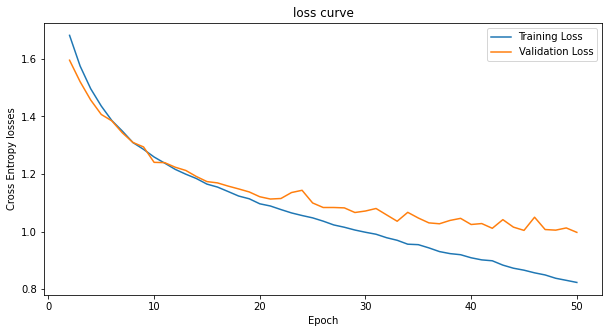

0.8579224582780829


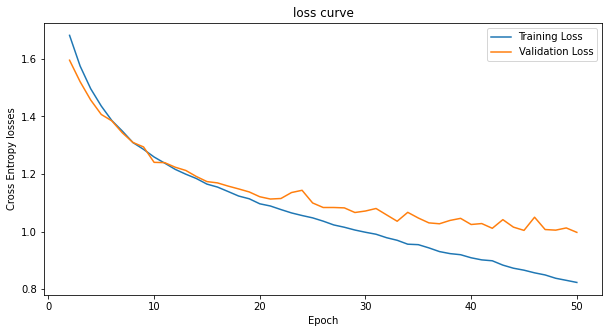

In [ ]:
plot_the_loss_curve(epochs, train_losses, validation_losses)

In [ ]:
test_loss, test_acc = test_model(model, testloader)
print()
print('accuracy on the test set: ', float(test_acc))

EPOCH[TEST]1/1: 100%|██████████| 3589/3589 [31:50<00:00,  1.88it/s, loss=1.04, acc=0.61]


accuracy on the test set:  0.6104764342308044

accuracy on the test set:  0.6104764342308044
